In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=d788298a466fcbd70f9e855180ebd76b98cc44e09ffcdba61a7cd4b519b7c142
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 15 20:58:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 2.56 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [6]:
import qmc.tf.layers as layers
import qmc.tf.models as models

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1]
X = X[:,0:-1]

In [ ]:
y.shape

(506,)

In [ ]:
X.shape

(506, 13)

Los labels van de 1 a 5

In [ ]:
print(max(y))
print(min(y))

[1.]
[0.]


In [ ]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((506,1))
X = np.float64(X)

Normalizando los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

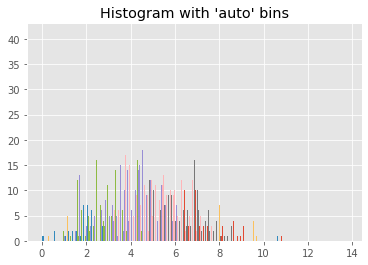

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [ ]:
print(np.mean(distances))
print(np.median(distances))

4.724219772373316
4.6649042859342265


Gamma:

In [ ]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.04480637549450039
0.04595306942337859


In [ ]:
for i in range(10,20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((300,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 13+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(13, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((206,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(13, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 11
------------ 1 beta= 20.98187687418934 gamma= 0.04095576543148954 learning_rate= 0.0009979282582046928 alpha= 0.14913747859449655 dim_x= 473 num_eig= 29
------mae =  0.29
------------ 2 beta= 20.485220233073647 gamma= 0.09305505964484745 learning_rate= 0.0009492250482456459 alpha= 0.6745501184141052 dim_x= 266 num_eig= 16
------mae =  0.27999999999999997
------------ 3 beta= 9.635558031525985 gamma= 0.062208648565894226 learning_rate= 0.0007524102477523538 alpha= 0.7665146747948126 dim_x= 328 num_eig= 20
------mae =  0.3433333333333333
------------ 4 beta= 10.762465144828068 gamma= 0.060375991987208055 learning_rate= 0.0004197209549075074 alpha= 0.7730597659907441 dim_x= 912 num_eig= 228
------mae =  0.3466666666666666
------------ 5 beta= 0.4605382327517116 gamma= 0.02911039604413307 learning_rate= 0.0009584212052660804 alpha= 0.6849473519781559 dim_x= 15 num_eig= 0
------mae =  0.33999999999999997
------------ 6 beta= 2.3391349102013708 gam

2nd try

In [ ]:
for i in range(10,20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((300,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 13+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(13, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((206,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(13, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 11
------------ 1 beta= 24.59312792713653 gamma= 0.0967503158109135 learning_rate= 0.0009444061434691887 alpha= 0.03639868445993322 dim_x= 206 num_eig= 103
------mae =  0.30333333333333334
------------ 2 beta= 16.280886650318873 gamma= 0.04717623622941286 learning_rate= 0.0005886823352862406 alpha= 0.9935024961168673 dim_x= 352 num_eig= 176
------mae =  0.34
------------ 3 beta= 3.6728248865415978 gamma= 0.01876337057658275 learning_rate= 0.00014653958076797503 alpha= 0.5539553105368984 dim_x= 297 num_eig= 148
------mae =  0.37333333333333335
------------ 4 beta= 10.842750756909192 gamma= 0.012831156145500011 learning_rate= 0.00010609225528791632 alpha= 0.835729318601239 dim_x= 660 num_eig= 330
------mae =  0.4166666666666667
------------ 5 beta= 10.953053858648751 gamma= 0.08127543744079427 learning_rate= 0.00016515222405906693 alpha= 0.0043047591360874105 dim_x= 296 num_eig= 148
------mae =  0.3333333333333333
------------ 6 beta= 17.364106479

In [7]:
for i in range(14,20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((300,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 13+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(13, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((206,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(13, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 15
------------ 1 beta= 8.248960224864177 gamma= 0.0908343777571052 learning_rate= 0.0004045121869306819 alpha= 0.15804512931725478 dim_x= 14 num_eig= 7
------mae =  0.36666666666666664
------------ 2 beta= 1.705800501751606 gamma= 0.047482956814508925 learning_rate= 4.098290758357648e-05 alpha= 0.4271884216555606 dim_x= 914 num_eig= 57
------mae =  0.3166666666666666
------------ 3 beta= 10.579405508905005 gamma= 0.0991568548776387 learning_rate= 0.0005720513064852012 alpha= 0.34633315588611857 dim_x= 733 num_eig= 366
------mae =  0.32333333333333336
------------ 4 beta= 4.362880869878783 gamma= 0.06415985136599771 learning_rate= 0.00014780358786514126 alpha= 0.648392781126475 dim_x= 47 num_eig= 23
------mae =  0.36666666666666664
------------ 5 beta= 11.98315148313469 gamma= 0.08560199178901073 learning_rate= 0.0005078172353165184 alpha= 0.05931112420140283 dim_x= 639 num_eig= 39
------mae =  0.2833333333333333
------------ 6 beta= 14.55866553